In [1]:
import sys
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rampy import baseline
from scipy.signal import savgol_filter

sys.path.append('../src')

In [2]:
tRaman_PATH = '../data/LK99/tRaman'

In [3]:
# Define paths for data processing
output_dir = os.path.join(tRaman_PATH, 'processed') 
raw_tRaman_PATH = os.path.join(tRaman_PATH, 'bin')
os.makedirs(output_dir, exist_ok=True)

def extract_temperature(filename):
    """Extract temperature value from filename."""
    try:
        return float(os.path.basename(filename)[:-6])  # Remove -1.CSV suffix
    except ValueError:
        return None

def load_and_validate_data(file_path, reference_shifts=None):
    """Load CSV data and validate Raman shifts against reference."""
    df = pd.read_csv(file_path, header=None, names=['raman_shift', 'intensity'])
    
    if reference_shifts is not None:
        if not np.array_equal(df['raman_shift'].values, reference_shifts):
            raise ValueError(f"Raman shifts in {file_path} do not match reference measurements")
    
    return df

# Get temperature-sorted file paths
tRaman_files = glob.glob(os.path.join(raw_tRaman_PATH, '*-1.CSV'))
temp_file_pairs = [(extract_temperature(f), f) for f in tRaman_files]
temp_file_pairs = [(t, f) for t, f in temp_file_pairs if t is not None]
temp_file_pairs.sort()
temperatures, tRaman_files = zip(*temp_file_pairs)

print(f"Processing data for temperatures (K): {temperatures}")

# Load and process all files
reference_shifts = None
processed_data = []

for temp, file in zip(temperatures, tRaman_files):
    df = load_and_validate_data(file, reference_shifts)
    if reference_shifts is None:
        reference_shifts = df['raman_shift'].values
    
    df['temperature'] = temp
    processed_data.append(df)

# Combine all data and create wide format
data = pd.concat(processed_data, ignore_index=True)
data_wide = data.pivot(index='raman_shift', columns='temperature', values='intensity')

# Save processed data
data_wide.to_csv(os.path.join(output_dir, 'tRaman_data_wide.csv'))

print("Saved processed data to:")
print(f"- wide format: {os.path.join(output_dir, 'tRaman_data_wide.csv')}")

# Display first few rows of processed data
data_wide.head()


Processing data for temperatures (K): (300.0, 350.0, 400.0, 450.0, 500.0)
Saved processed data to:
- wide format: ../data/LK99/tRaman\processed\tRaman_data_wide.csv


temperature,300.0,350.0,400.0,450.0,500.0
raman_shift,,,,,
50.17602,171.2264,335.3758,247.1462,629.6158,703.5471
52.10448,185.3873,370.2922,271.1320,668.9344,777.5427
54.03295,195.8020,408.0715,292.2957,705.2650,854.4731
55.96142,193.0070,433.5731,294.8016,713.1357,886.0290
57.88988,182.5216,424.1681,286.9361,700.3641,878.9653


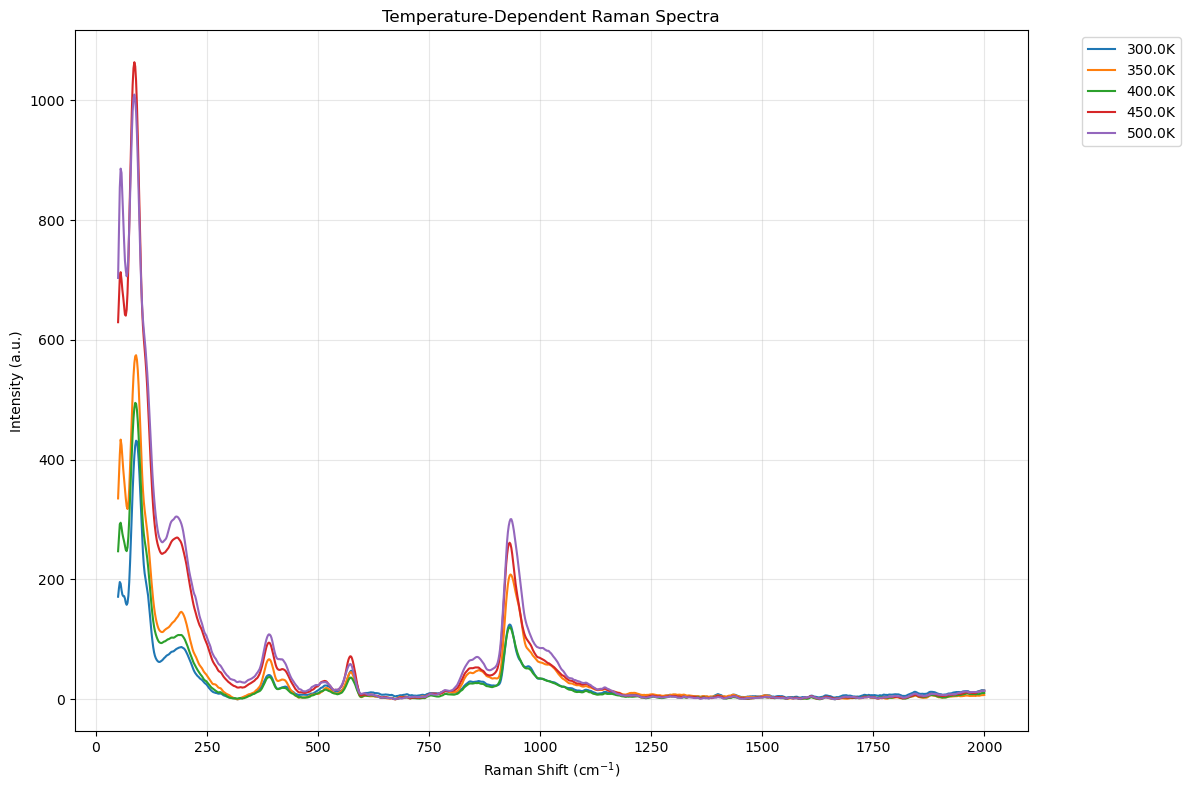

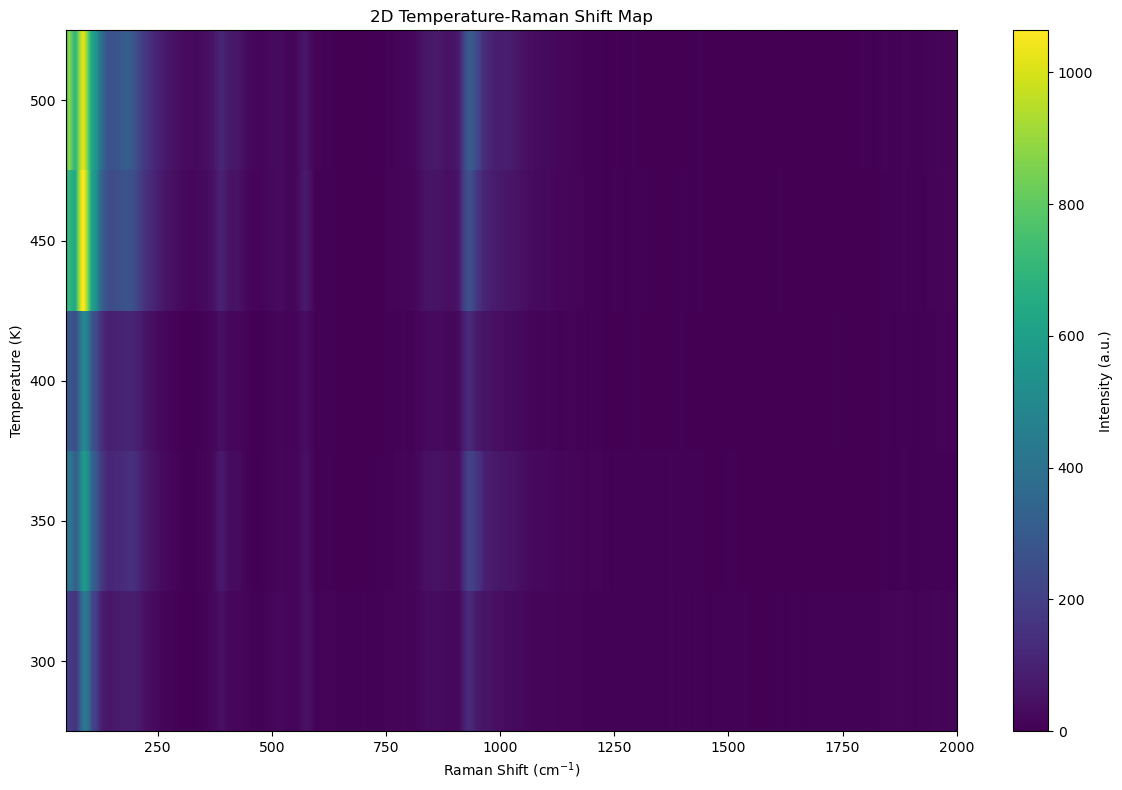

In [4]:
# Create a waterfall plot of Raman spectra at different temperatures
plt.figure(figsize=(12, 8))

# Plot spectra with vertical offset based on temperature
offset = 0
for temp in temperatures:
    plt.plot(data_wide.index, 
             data_wide[temp] + offset,
             linewidth=1.5,
             label=f'{temp}K')
    offset += 0  # Increment offset for next spectrum

plt.xlabel('Raman Shift (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')
plt.title('Temperature-Dependent Raman Spectra')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Create a 2D color map visualization
plt.figure(figsize=(12, 8))

# Prepare data for 2D plot
x = data_wide.index.values
y = np.array(temperatures)
z = data_wide.T.values

# Create color mesh plot
plt.pcolormesh(x, y, z, shading='auto', cmap='viridis')
plt.colorbar(label='Intensity (a.u.)')

plt.xlabel('Raman Shift (cm$^{-1}$)')
plt.ylabel('Temperature (K)')
plt.title('2D Temperature-Raman Shift Map')

plt.tight_layout()
plt.show()
